In [121]:
import pickle as pkl

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 150 

from keras.datasets import imdb
from keras.callbacks import CSVLogger

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model

In [2]:
from pipe import Data

In [110]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Building a CNN

In [3]:
drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

#drugbank = drugbank.sample(7500)

In [ ]:
drugbank = drugbank_reader.__next__().drop('Unnamed: 0', axis = 1)
drugbank_test = drugbank_reader.__next__().drop('Unnamed: 0', axis = 1)

In [31]:
drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

In [4]:
drugbank = drugbank_reader.sample(7500, replace = False)
drugbank_test = drugbank_reader.sample(7500, replace = False)


In [8]:
drugbank['target_gene_encoded_padded']

In [3]:
amino = Data().load_conv_train()
gene = Data().load_conv_train(is_amino=False)

In [35]:
gene.head()

,drug_fingerprint,target_gene_code,label,set,d_enc,t_enc,d_len,t_len,d_enc_p,t_enc_p
0,2246728737 3542456614 2245384272 1506563592 22...,ATGGCGCACGTCCGAGGCTTGCAGCTGCCTGGCTGCCTGGCCCTGG...,1,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...","[0, 5, 2, 2, 1, 2, 1, 0, 1, 2, 5, 1, 1, 2, 0, ...",3003,1869,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,2246728737 3537119515 2245273601 2423543607 22...,ATGAAGCAGCGGTTCTCGGCGCTGCAGCTGCTGAAGCTGCTGCTGC...,1,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...","[0, 5, 2, 0, 0, 2, 1, 0, 2, 1, 2, 2, 5, 5, 1, ...",1769,2100,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,2246728737 3537119515 2245273601 2423543607 22...,ATGGCAAACAGTGCCTCTCCTGAACAGAATCAAAATCACTGTTCAG...,1,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...","[0, 5, 2, 2, 1, 0, 0, 0, 1, 0, 2, 5, 2, 1, 1, ...",1769,987,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,2968968094 2142032900 2968968094 2117068077 29...,ATGCTCATGGCGTCCACCACTTCCGCTGTGCCTGGGCATCCCTCTC...,1,train,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...","[0, 5, 2, 1, 5, 1, 0, 5, 2, 2, 1, 2, 5, 1, 1, ...",1431,1116,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,2968968094 2142032900 2968968094 2117068077 29...,ATGCGTCTCTCCGCCGGTCCCGACGCGGGGCCCTCGGGCAACTCCA...,1,train,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...","[0, 5, 2, 1, 2, 5, 1, 5, 1, 5, 1, 1, 2, 1, 1, ...",1431,1257,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [4]:
targ_string = 'amino'
if targ_string == 'gene':
    data = gene.copy()
elif targ_string == 'amino':
    data = amino.copy()

# d_len = 200
# # t_len = 2000 # for aminos
# t_len = 5000 # for genes

# data = data[(data.d_len <= d_len) & (data.t_len <= t_len)] # for aminos
# data['d_enc_p'] = data['d_enc_p'].apply(lambda x: x[:d_len])
# data['t_enc_p'] = data['t_enc_p'].apply(lambda x: x[:t_len])

In [6]:
train = data[data.set=='train'].copy()#.sample(n=500)
test  = train.sample(frac=.3, replace = True).copy()
val   = data[data.set=='val'].copy()

# Remove testing indicies
train = train.loc[list(set(train.index.tolist()) - set(test.index.tolist())), :].reset_index(drop=True)
test.reset_index(drop=True, inplace=True)
train.head()

,drug_fingerprint,target_amino_code,label,set,d_enc,t_enc,d_len,t_len,d_enc_p,t_enc_p
0,2246728737 3542456614 2245384272 1506563592 22...,MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANT...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...","[10, 0, 6, 18, 14, 5, 9, 13, 9, 12, 5, 1, 9, 0...",3003,622,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,2246728737 3537119515 2245273601 2423543607 22...,MKQRFSALQLLKLLLLLQPPLPRALREALCPEPCNCVPDGALRCPG...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...","[10, 8, 13, 14, 4, 15, 0, 9, 13, 9, 9, 8, 9, 9...",1769,699,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,2246728737 3537119515 2245273601 2423543607 22...,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...","[10, 0, 11, 15, 0, 15, 12, 3, 13, 11, 13, 11, ...",1769,328,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,2968968094 2142032900 2968968094 2117068077 29...,MLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSI...,1.0,train,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...","[10, 9, 10, 0, 15, 16, 16, 15, 0, 18, 12, 5, 6...",1431,371,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,2968968094 2142032900 2968968094 2117068077 29...,MRLSAGPDAGPSGNSSPWWPLATGAGNTSREAEALGEGNGPPRDVR...,1.0,train,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...","[10, 14, 9, 15, 0, 5, 12, 2, 0, 5, 12, 15, 5, ...",1431,418,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [38]:
X_0 = np.array(train['d_enc_p'].tolist())
X_1 = np.array(train['t_enc_p'].tolist())
Y = np.array(train['label'].tolist())

In [39]:
X_0_test = np.array(test['d_enc_p'].tolist())
X_1_test = np.array(test['t_enc_p'].tolist())
Y_test = np.array(test['label'].tolist())

In [40]:
X_0_val = np.array(val['d_enc_p'].tolist())
X_1_val = np.array(val['t_enc_p'].tolist())
Y_val = np.array(val['label'].tolist())

In [41]:
print(X_0.shape)
print(X_1.shape)

(20865, 9501)
(20865, 7073)


In [42]:
# X = np.hstack((X_0, X_1))
# X_test = np.hstack((X_0_test, X_1_test))

In [43]:
X_0_test.shape

(8444, 9501)

In [44]:
X_0_val.shape

(13976, 9501)

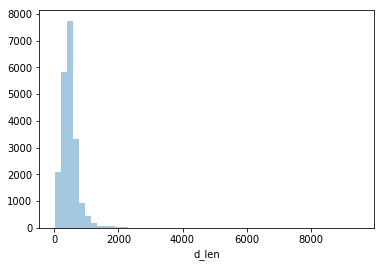

In [45]:
sns.distplot(train['d_len'], kde=False)

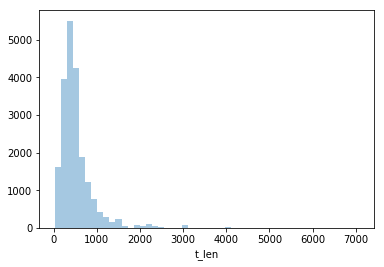

In [46]:
sns.distplot(train['t_len'], kde=False)

In [47]:
train.head()

,drug_fingerprint,target_amino_code,label,set,d_enc,t_enc,d_len,t_len,d_enc_p,t_enc_p
0,2246728737 3542456614 2245384272 1506563592 22...,MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANT...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...","[10, 0, 6, 18, 14, 5, 9, 13, 9, 12, 5, 1, 9, 0...",3003,622,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,2246728737 3537119515 2245273601 2423543607 22...,MKQRFSALQLLKLLLLLQPPLPRALREALCPEPCNCVPDGALRCPG...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...","[10, 8, 13, 14, 4, 15, 0, 9, 13, 9, 9, 8, 9, 9...",1769,699,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,2246728737 3537119515 2245273601 2423543607 22...,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,1.0,train,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...","[10, 0, 11, 15, 0, 15, 12, 3, 13, 11, 13, 11, ...",1769,328,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,2968968094 2142032900 2968968094 2117068077 29...,MLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSI...,1.0,train,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...","[10, 9, 10, 0, 15, 16, 16, 15, 0, 18, 12, 5, 6...",1431,371,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,2968968094 2142032900 2968968094 2117068077 29...,MRLSAGPDAGPSGNSSPWWPLATGAGNTSREAEALGEGNGPPRDVR...,1.0,train,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...","[10, 14, 9, 15, 0, 5, 12, 2, 0, 5, 12, 15, 5, ...",1431,418,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


#### Trimming the feature martrix to minimize padding. This trimming may result in loss of data from the largest SMILE and fingerprints, but are neccesary to reduce the amount of padding

In [48]:
## Trim the X of -1's. Might loose actual sequences
padding_fractions = []
padding_fraction = 0.9

while padding_fraction > 0.5:
    
    padding_fraction = len(X_0[np.where(X_0 == -1)]) / (X_0.shape[0] * X_0.shape[1])
    padding_fractions.append(padding_fraction)
    trimming_factor = 0.1

    X_0 = X_0[:,int(X_0.shape[1]*trimming_factor) : X_0.shape[1] - int(X_0.shape[1]*trimming_factor)]
    X_1 = X_1[:,int(X_1.shape[1]*trimming_factor) : X_1.shape[1] - int(X_1.shape[1]*trimming_factor)]

    X_0_test = X_0_test[:,int(X_0_test.shape[1]*trimming_factor) : X_0_test.shape[1] - int(X_0_test.shape[1]*trimming_factor)]
    X_1_test = X_1_test[:,int(X_1_test.shape[1]*trimming_factor) : X_1_test.shape[1] - int(X_1_test.shape[1]*trimming_factor)]

    X_0_val = X_0_val[:,int(X_0_val.shape[1]*trimming_factor) : X_0_val.shape[1] - int(X_0_val.shape[1]*trimming_factor)]
    X_1_val = X_1_val[:,int(X_1_val.shape[1]*trimming_factor) : X_1_val.shape[1] - int(X_1_val.shape[1]*trimming_factor)]



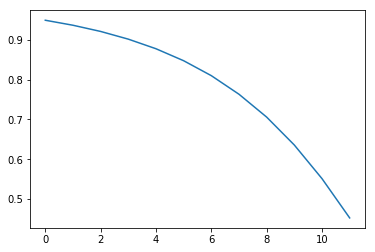

In [49]:
plt.plot(padding_fractions)

In [82]:
# +1 to shift all values by 1 so the -1 padding becomes 0.

X = np.hstack((X_0, X_1)) + 1
X_test = np.hstack((X_0_test, X_1_test)) + 1
X_val = np.hstack((X_0_val, X_1_val)) + 1

In [79]:
X_mixed_index = np.random.randint(len(X), size=int(len(X)/2))
X_val_mixed_index = np.random.randint(len(X_val), size=int(len(X_val)/2))

In [95]:
Y[X_mixed_index].shape

(10432,)

In [96]:
Y_val[X_val_mixed_index].shape

(6988,)

In [99]:
X_mixed = np.vstack((X[X_mixed_index], X_val[X_val_mixed_index]))
X_mixed_val = np.vstack((X[~ X_mixed_index], X_val[ ~ X_val_mixed_index]))

#Y is shaped as a horizontal array
Y_mixed = np.hstack((Y[X_mixed_index], Y_val[X_val_mixed_index]))
Y_mixed_val = np.hstack((Y[~X_mixed_index], Y_val[~X_val_mixed_index]))

In [100]:
X_mixed

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 19,  8,  6],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 11, 14, 13],
       [ 7,  3,  4, ...,  0,  0,  0]])

In [101]:
X_mixed_val

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 13,  1,  4],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  5, 17, 13],
       [ 4,  9,  5, ...,  0,  0,  0],
       [ 9,  2,  9, ...,  0,  0,  0]])

In [104]:
#embedding_dims = 16
hidden_dims = 512
hidden_dims_2 = 256
hidden_dims_3 = 128
batch_size = 500
epochs = 30
#maxlen = 

model = Sequential()
#model.add(Embedding(X_0.shape[1],
#                    embedding_dims,
#                    input_length=maxlen))

#model.add(Dropout(0.2))
model.add(Conv1D(512,
                 1024,
                 activation='relu',
                 strides=2))


model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_2))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_3))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [30]:
csv_logger = CSVLogger(('%s_log.csv') % targ_string, append=True, separator=';')

model.fit(X[..., np.newaxis], Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test[..., np.newaxis], Y_test),
          callbacks=[csv_logger])

In [106]:
csv_logger = CSVLogger(('%s_log.csv') % targ_string, append=True, separator=';')

model.fit(X_mixed[..., np.newaxis], Y_mixed,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test[..., np.newaxis], Y_test),
          callbacks=[csv_logger])

Train on 17420 samples, validate on 8444 samples
Epoch 1/30
17420/17420 [==============================] - 29s 2ms/step - loss: 0.6055 - acc: 0.6625 - val_loss: 0.7405 - val_acc: 0.5338
Epoch 2/30
17420/17420 [==============================] - 28s 2ms/step - loss: 0.6078 - acc: 0.6623 - val_loss: 0.6038 - val_acc: 0.6826
Epoch 3/30
17420/17420 [==============================] - 29s 2ms/step - loss: 0.5685 - acc: 0.6982 - val_loss: 0.5946 - val_acc: 0.6711
Epoch 4/30
17420/17420 [==============================] - 28s 2ms/step - loss: 0.5508 - acc: 0.7200 - val_loss: 0.5560 - val_acc: 0.7072
Epoch 5/30
17420/17420 [==============================] - 29s 2ms/step - loss: 0.5093 - acc: 0.7525 - val_loss: 0.5264 - val_acc: 0.7448
Epoch 6/30
17420/17420 [==============================] - 28s 2ms/step - loss: 0.6387 - acc: 0.6614 - val_loss: 0.6076 - val_acc: 0.6813
Epoch 7/30
17420/17420 [==============================] - 31s 2ms/step - loss: 0.5877 - acc: 0.6885 - val_loss: 0.6354 - val_acc:

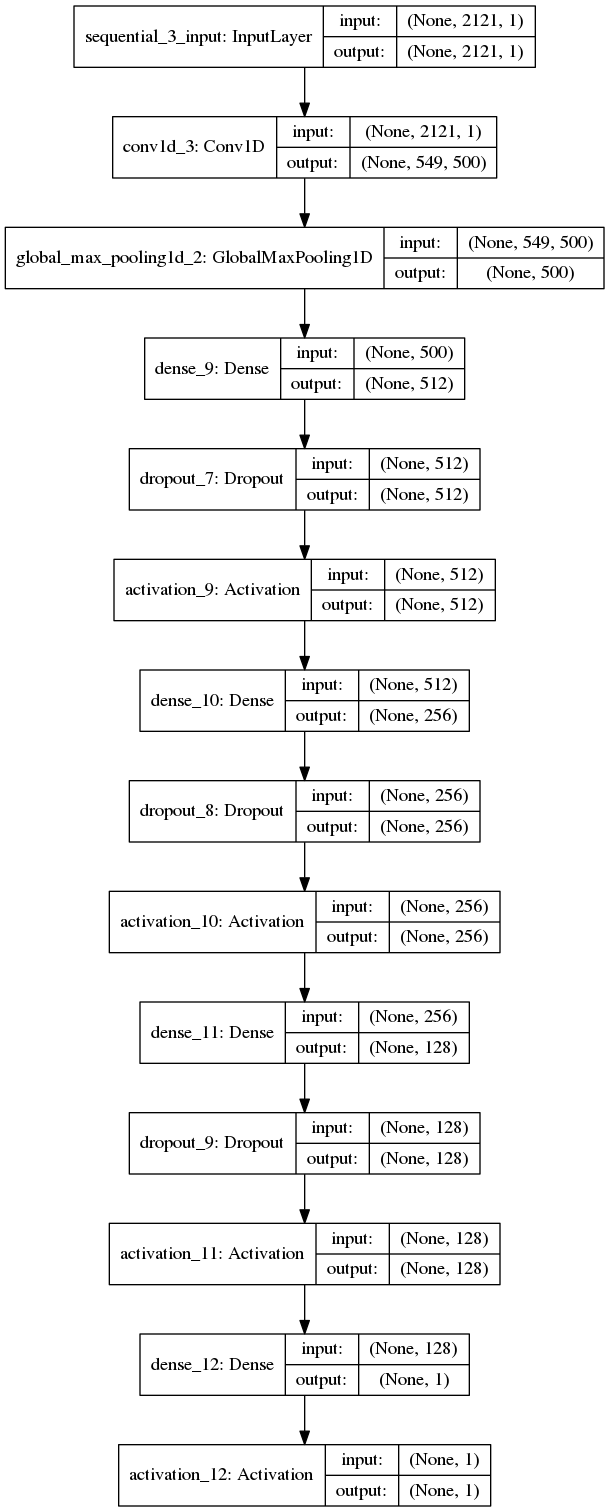

In [26]:
plot_model(model, show_shapes = True)

In [107]:
Y_pred = model.predict(X_mixed_val[..., np.newaxis])

In [108]:
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

In [89]:
f1_score(Y_test, Y_pred)

0.8094935905571773

In [59]:
model.save('data/models/pure_cnn_amino.model')

### External Validation

In [112]:
Y_pred = model.predict(X_mixed_val[..., np.newaxis])
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

Confusion matrix, without normalization
[[5153 3717]
 [ 804 7746]]
Normalized confusion matrix
[[0.58094701 0.41905299]
 [0.09403509 0.90596491]]


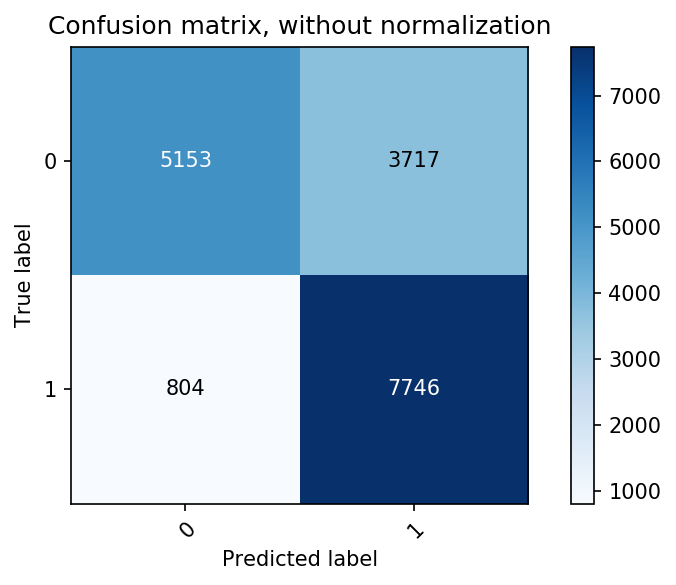

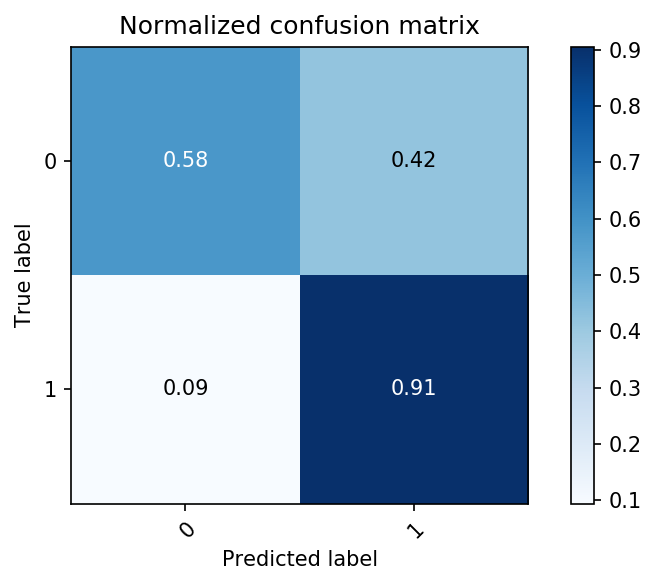

In [122]:
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')



In [115]:
f1_score(Y_mixed_val, Y_pred)

0.7740968370559137

In [118]:
recall_score(Y_mixed_val, Y_pred)

0.9059649122807018

In [120]:
precision_score(Y_mixed_val, Y_pred)

0.6757393352525517

In [105]:
np.unique(X_val[0])[0]

-1